c:\Users\zanca\AppData\Local\Programs\Python\Python311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


['sadness', 'sadness', 'joy', 'sadness', 'love', 'love', 'joy', 'joy', 'joy', 'anger']


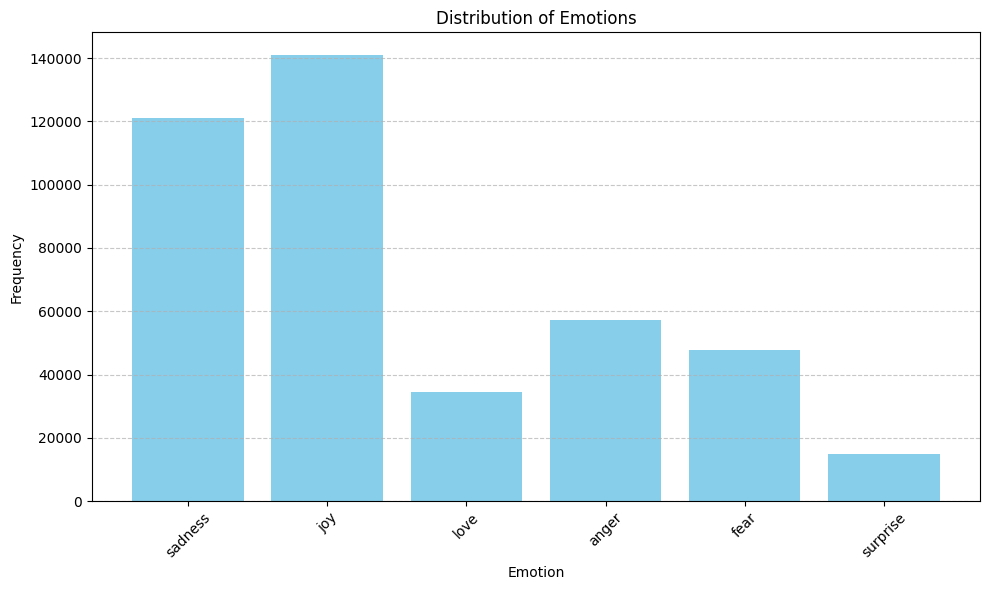

In [7]:
from datasets import load_dataset

# Path to the JSONL file containing the dataset
file_path = "/Users/zanca/OneDrive/Desktop/ML-Emotion_Classifier/data.jsonl/data.jsonl"

# Load the dataset from the JSONL file
dataset = load_dataset("json", data_files=file_path)

#print(dataset)


# Access the labels
labels = dataset["train"]["label"]
# label 0 = sadness
# label 1 = joy
# label 2 = love
# label 3 = anger
# label 4 = fear
# label 5 = surprise

# Convert the labels to their corresponding emotions
emotions = ["sadness", "joy", "love", "anger", "fear", "surprise"]
emotions = [emotions[label] for label in labels]
print (emotions[:10]  )

# plot the distribution of the emotions
import matplotlib.pyplot as plt


# Count the occurrences of each emotion
emotion_counts = {}
for emotion in emotions:
    if emotion in emotion_counts:
        emotion_counts[emotion] += 1
    else:
        emotion_counts[emotion] = 1

# Plot the distribution of the emotions
plt.figure(figsize=(10, 6))
plt.bar(emotion_counts.keys(), emotion_counts.values(), color='skyblue')
plt.xlabel('Emotion')
plt.ylabel('Frequency')
plt.title('Distribution of Emotions')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


        









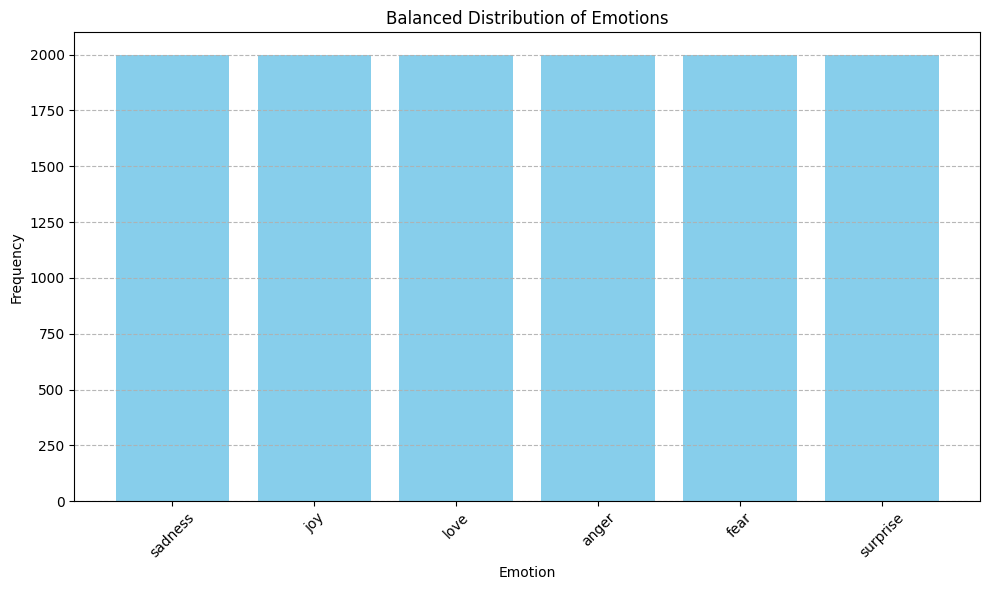

In [8]:
from collections import Counter
import random

# Extract the feature matrix X and the target labels y
X_train = [sample['text'] for sample in dataset["train"]]
y_train = [sample['label'] for sample in dataset["train"]]

# Calculate the frequency of each class
class_counts = Counter(y_train)

# Determine the minimum number of samples in any class
min_class_count = 2000

# Create a list to store the balanced data
balanced_X_train = []
balanced_y_train = []

# Undersample the majority classes to match the size of the minority class
for label in class_counts:
    # Select samples from the current class randomly
    samples = [i for i, y in enumerate(y_train) if y == label]
    selected_samples = random.sample(samples, min_class_count)
    
    # Add the selected samples to the balanced dataset
    balanced_X_train.extend([X_train[i] for i in selected_samples])
    balanced_y_train.extend([y_train[i] for i in selected_samples])

# Count the occurrences of each class in the balanced dataset
balanced_class_counts = Counter(balanced_y_train)

# Access the labels and convert them to their corresponding emotions
labels = balanced_y_train
# label 0 = sadness
# label 1 = joy
# label 2 = love
# label 3 = anger
# label 4 = fear
# label 5 = surprise
emotions = ["sadness", "joy", "love", "anger", "fear", "surprise"]
emotions = [emotions[label] for label in labels]

# Count the occurrences of each emotion
emotion_counts = Counter(emotions)

# Plot the distribution of the emotions
plt.figure(figsize=(10, 6))
plt.bar(emotion_counts.keys(), emotion_counts.values(), color='skyblue')
plt.xlabel('Emotion')
plt.ylabel('Frequency')
plt.title('Balanced Distribution of Emotions')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.9)
plt.tight_layout()
plt.show()





In [16]:
import torch
from torch.optim import Adam
from torch.optim.lr_scheduler import StepLR
from torch.nn.utils import clip_grad_norm_
from collections import Counter

# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Training on {device}")

# Hyperparameters
embedding_dim = max(len(sentence) for sentence in X_train)  # Dimension of the word embeddings
hidden_dim = 100  # Dimension of the hidden layer
output_dim = 6  # Number of classes
iterations = 50  # Number of training iterations
learning_rate = 0.01  # Initial learning rate for the optimizer
batch_size = 100  # Batch size for training

# Create a dictionary to store the word frequencies
word_freqs = Counter()

# Update the word frequencies
for sentence in balanced_X_train:
    for word in sentence.split():
        word_freqs[word] += 1

# Create a vocabulary
vocab = {word: index + 2 for index, (word, _) in enumerate(word_freqs.most_common())}
vocab['<pad>'] = 0
vocab['<unk>'] = 1

# Convert the sentences to sequences of indices
X_train = [[vocab.get(word, vocab['<unk>']) for word in sentence.split()] for sentence in balanced_X_train]

# Define the maximum sentence length
max_len = max(len(sentence) for sentence in X_train)

# Pad the sequences to the maximum sentence length
X_train = [sentence + [0] * (max_len - len(sentence)) for sentence in X_train]

# Convert the target labels to tensors
y_train = torch.tensor(balanced_y_train).to(device)

# Convert the feature matrix to a tensor
X_train = torch.tensor(X_train).to(device)

# Define the model
class LSTMClassifier(torch.nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim):
        super(LSTMClassifier, self).__init__()

        # Embedding layer
        self.embedding = torch.nn.Embedding(vocab_size, embedding_dim, padding_idx=0)

        # LSTM layer
        self.lstm = torch.nn.LSTM(embedding_dim, hidden_dim, batch_first=True)

        # Dense layer
        self.dense = torch.nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        # Embed the input
        x = self.embedding(x)

        # Propagate the embeddings through the LSTM layer
        x, _ = self.lstm(x)

        # Extract the output of the last time step
        x = x[:, -1, :]

        # Propagate the output through the dense layer
        x = self.dense(x)

        return x

# Instantiate the model and move it to the GPU if available
model = LSTMClassifier(len(vocab), embedding_dim, hidden_dim, output_dim).to(device)

# Define the loss function and the optimizer
criterion = torch.nn.CrossEntropyLoss()
optimizer = Adam(model.parameters(), lr=learning_rate)

# Define the learning rate scheduler
scheduler = StepLR(optimizer, step_size=30, gamma=0.1)  # Reduce learning rate by a factor of 0.1 every 30 epochs

# Train the model
for epoch in range(iterations):
    # Randomly shuffle the data
    indices = torch.randperm(X_train.size(0), device=device)
    X_train_shuffled = X_train[indices]
    y_train_shuffled = y_train[indices]

    # Mini-batch training
    for i in range(0, X_train.size(0), batch_size):
        # Get mini-batch
        X_batch = X_train_shuffled[i:i+batch_size]
        y_batch = y_train_shuffled[i:i+batch_size]

        # Forward pass
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)

        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        clip_grad_norm_(model.parameters(), max_norm=1)  # Clip gradients to prevent exploding gradients
        optimizer.step()

    # Update the learning rate
    scheduler.step()

    # Print the loss at every 100th epoch
    if (epoch + 1) % 100 == 0:
        print(f'Epoch [{epoch + 1}/{iterations}], Loss: {loss.item():.4f}, Learning Rate: {scheduler.get_lr()[0]}')

# Save the model
torch.save(model.state_dict(), 'model.ckpt')

# Load the model
model = LSTMClassifier(len(vocab), embedding_dim, hidden_dim, output_dim).to(device)
model.load_state_dict(torch.load('model.ckpt'))
model.eval()






#---------------------------------------------------------------------#





from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score


    


# Calculate evaluation metrics
accuracy = accuracy_score(y_train.cpu(), predicted.cpu())
precision = precision_score(y_train.cpu(), predicted.cpu(), average='weighted')
recall = recall_score(y_train.cpu(), predicted.cpu(), average='weighted')
f1 = f1_score(y_train.cpu(), predicted.cpu(), average='weighted')

# Print the evaluation metrics
print(f'Validation Loss: {val_loss:.4f}')
print(f'Accuracy: {accuracy:.4f}')
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1-score: {f1:.4f}')











Training on cuda


NameError: name 'predicted' is not defined

In [45]:
from datasets import load_dataset
import torch
from torch.nn.utils.rnn import pad_sequence
from transformers import BertTokenizer

# Load the dataset
dataset = load_dataset("dair-ai/emotion")

# Access the validation split
validation_data = dataset["validation"]

# Extract the features and labels from the validation data
X_val = validation_data["text"]
y_val = validation_data["label"]

# Instantiate the BERT tokenizer
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

# Tokenize and encode the text data
encoded_X_val = [tokenizer.encode(text, padding='max_length', truncation=True, max_length=128) for text in X_val]

# Pad sequences to ensure uniform length
padded_X_val = pad_sequence([torch.tensor(seq) for seq in encoded_X_val], batch_first=True, padding_value=0)

# Convert the target labels to tensors and move them to the appropriate device
y_val = torch.tensor(y_val).to(device)

# Evaluate the model on the validation set
model.eval()  # Set the model to evaluation mode
with torch.no_grad():  # Disable gradient calculation
    # Move the input data to the appropriate device
    padded_X_val = padded_X_val.to(device)

    # Forward pass to get predictions
    outputs = model(padded_X_val)

    # Calculate the loss
    val_loss = criterion(outputs, y_val)

    # Get the predicted labels
    _, predicted = torch.max(outputs, 1)

# Calculate evaluation metrics (e.g., accuracy, precision, recall, F1-score)
accuracy = (predicted == y_val).float().mean().item()
precision = precision_score(y_val.cpu(), predicted.cpu(), average='weighted')
recall = recall_score(y_val.cpu(), predicted.cpu(), average='weighted')
f1 = f1_score(y_val.cpu(), predicted.cpu(), average='weighted')

# Print the evaluation metrics
print(f'Validation Loss: {val_loss:.4f}')
print(f'Accuracy: {accuracy:.4f}')
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1-score: {f1:.4f}')


RuntimeError: CUDA error: device-side assert triggered
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1.
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.
